In [374]:
import numpy as np
import cv2
import glob
import yaml
import pathlib

In [375]:
with open("calibration_matrix.yaml", "r") as f:
    data = yaml.safe_load(f)
data

{'camera_matrix': [[7399.826827621343, 0.0, 1045.9175570309699],
  [0.0, 7380.579608208009, 992.1662655253949],
  [0.0, 0.0, 1.0]],
 'dist_coeff': [[0.13189837790145703,
   12.91832534258776,
   0.027789493753352507,
   1.1351675807449437e-05,
   -197.76139780826622]]}

In [376]:
src_points = np.array([
    [[1080/2, 1920/2]],    # Center point
    [[1080, 1920]],    # Bottom-right
    [[1080/2, 1920/2]],     # Top-left
    [[0,0]]
], dtype=np.float32)


h,  w = (1080,1920)

mtx = np.array(data['camera_matrix'])
dist = np.array(data['dist_coeff'])
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

cv2.undistortPoints(src_points, cameraMatrix=mtx, distCoeffs=dist)



array([[[-0.06832577, -0.00448569]],

       [[ 0.00455445,  0.12389232]],

       [[-0.06832577, -0.00448569]],

       [[-0.14059833, -0.13476868]]], dtype=float32)

In [377]:
# some preparation
for s in src_points:
    x, y = s[0]
    x_n = (x - data['camera_matrix'][0][2]) / data['camera_matrix'][0][0]
    y_n = (y - data['camera_matrix'][1][2]) / data['camera_matrix'][1][1]
    print(f"({x}, {y}) \t-> ({x_n}, {y_n})")
    theta_h = np.arctan2(x_n, 1)
    theta_v = np.arctan2(y_n, 1)
    print(f"theta_h: {theta_h} rad, theta_v: {theta_v} rad")
    print(f"theta_h: {np.degrees(theta_h)} degree, theta_v: {np.degrees(theta_v)} degree")
    # 
    print("Using cv2.undistortPoints:")
    x_n, y_n = cv2.undistortPoints(s, cameraMatrix=np.array(data['camera_matrix'])
                                , distCoeffs=np.array(data['dist_coeff']))[0][0]
    theta_h = np.arctan2(x_n, 1)
    theta_v = np.arctan2(y_n, 1)
    print(f"theta_h: {theta_h} rad, theta_v: {theta_v} rad")
    print(f"theta_h: {np.degrees(theta_h)} degree, theta_v: {np.degrees(theta_v)} degree")

    print()


(540.0, 960.0) 	-> (-0.0683688373817791, -0.004358230279045094)
theta_h: -0.06826260970864624 rad, theta_v: -0.004358202685702262 rad
theta_h: -3.911159434854188 degree, theta_v: -0.24970662015332 degree
Using cv2.undistortPoints:
theta_h: -0.06821973802658765 rad, theta_v: -0.004485660880449275 rad
theta_h: -3.908703068411604 degree, theta_v: -0.25700943677668037 degree

(1080.0, 1920.0) 	-> (0.004605843320793744, 0.12571285505040186)
theta_h: 0.004605810752073155 rad, theta_v: 0.12505682090570538 rad
theta_h: 0.26389351732976735 degree, theta_v: 7.16522803722032 degree
Using cv2.undistortPoints:
theta_h: 0.004554413899137846 rad, theta_v: 0.12326420965291371 rad
theta_h: 0.2609486945763196 degree, theta_v: 7.062518978127698 degree

(540.0, 960.0) 	-> (-0.0683688373817791, -0.004358230279045094)
theta_h: -0.06826260970864624 rad, theta_v: -0.004358202685702262 rad
theta_h: -3.911159434854188 degree, theta_v: -0.24970662015332 degree
Using cv2.undistortPoints:
theta_h: -0.0682197380265

Show FOV 

In [378]:
def get_fov(camera_matrix, image_size):
    fx = camera_matrix[0][0]
    fy = camera_matrix[1][1]
    cx = camera_matrix[0][2]
    cy = camera_matrix[1][2]

    width, height = image_size

    fov_x = 2 * np.arctan(width / (2 * fx))
    fov_y = 2 * np.arctan(height / (2 * fy))

    return np.degrees(fov_x), np.degrees(fov_y)

for camera_matrix in [mtx, newcameramtx]:
    print(get_fov(camera_matrix, (1920, 1080)))

(14.783709357480339, 8.36917728948702)
(14.737458698092633, 8.412430166931882)


# Create Function to get the angle:

In [ ]:
def get_angles(camera_matrix, coordinates, VERBOSE = False):
    # coordinates is the boundbox of the image
    x = (coordinates[0] + coordinates[2])/2
    y = (coordinates[1] + coordinates[3])/2
    mtx, dist = np.array(data['camera_matrix']), np.array(data['dist_coeff'])

    src = np.array([[[x, y]]], dtype=np.float32)
    x_n, y_n = cv2.undistortPoints(src, cameraMatrix= mtx
                                    , distCoeffs= dist)[0][0]
    # y_n is z_n at the article

    theta_azimute = np.arctan2(1,x_n)
    phi_polar = np.arccos(y_n / np.sqrt(x_n**2 + y_n**2 + 1) )

    if VERBOSE:
        print(f"pixesl ({x},{y}) \t-> normalized pos: ({x_n:.2}, {y_n:.2}, 1) \t-> angle (azimute, polar): " + \
              f"({np.rad2deg(theta_azimute):.3}º, {np.rad2deg(phi_polar):.3}º) \t-> 800*cos: ({800*np.cos(theta_azimute):.1f},{800*np.cos(phi_polar):.1f})")

    return theta_azimute, phi_polar

print("Upper Left")
get_angles(data, (0, 0, 0, 0),True)
print("Center")
get_angles(data, (0, 0, 1920, 1080),True)
print("Lower right")
get_angles(data, (1920, 1080, 1920, 1080),True)
# get_angles(data, (1920, 0, 1920, 0),True)
# get_angles(data, (1080, 1920, 1080, 1920),True)

# x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
# y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
# z = radius * np.cos(theta_azimute)

Upper Left
pixesl (0.0,0.0) 	-> normalized pos: (-0.14, -0.13, 1) 	-> angle (azimute, polar): (98.0º, 97.6º) 	-> 800*cos: (-111.4,-105.8)
Center
pixesl (960.0,540.0) 	-> normalized pos: (-0.012, -0.062, 1) 	-> angle (azimute, polar): (90.7º, 93.5º) 	-> 800*cos: (-9.3,-49.1)
Lower right
pixesl (1920.0,1080.0) 	-> normalized pos: (0.12, 0.011, 1) 	-> angle (azimute, polar): (83.3º, 89.3º) 	-> 800*cos: (93.4,9.1)


(1.4537366725053402, 1.5594136838889625)

## Get values from a real flight (from CSV)

Using rotation angle of 7 degrees found

In [380]:
def rot_x(theta):
    rot_matrix = np.array([
        [1,        0,           0       ],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return(rot_matrix)

In [381]:
for track_id, sub in dfDistance.groupby('track_id'):
    print(track_id, sub)
    break

316.0     Unnamed: 0  coordinates_x1  coordinates_y1  coordinates_x2  \
0            0      760.806030       15.276432      894.252991   
1            1      768.597595       29.482830      901.469116   
2            2      779.217957       46.666573      908.189087   
3            3      785.063904       57.679661      913.947632   
4            4      792.693726       70.817871      919.455139   
..         ...             ...             ...             ...   
60          60     1596.700806       93.851868     1674.548218   
61          61     1613.085327       92.103607     1676.863281   
62          62     1631.983643       87.157608     1688.561401   
63          63     1662.769409       65.905396     1728.575439   
64          64     1668.675781       59.625252     1737.201538   

    coordinates_y2  current_frame  track_id  \
0        55.818954            1.0     316.0   
1        68.969795            2.0     316.0   
2        83.837723            3.0     316.0   
3        92.2

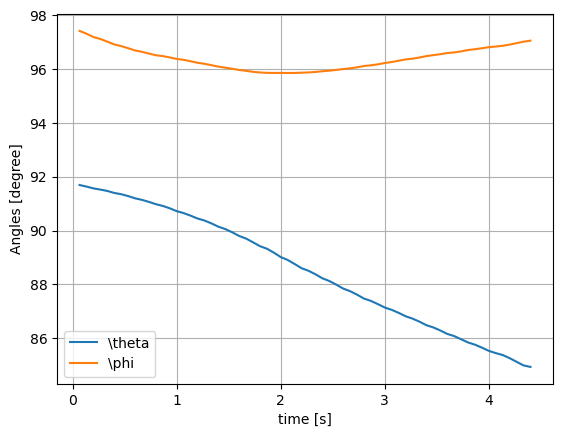

altura maxima 32.65 e minima 30.49


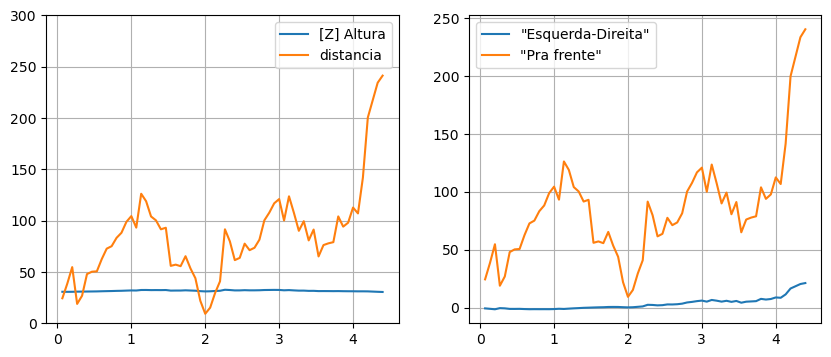

In [383]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
altura_camera = (12000 + 4360 + 12000 + 2500)* 10**-3

rotation_angle = np.deg2rad(7)
rotatation_matrix = rot_x(rotation_angle)

FPS = 15
CSVs = glob.glob('./results/*.csv')

CSV = CSVs[7] # choose a CSV file
dfDistance = pd.read_csv(CSV)

vector_angles = []
vector_cartesian = []
time_vector = []
for track_id, sub in dfDistance.groupby('track_id'):
    vector_angles = []
    vector_cartesian = []
    time_vector = []
    for i, row in sub.iterrows():
        coordinates = (row['coordinates_x1'], row['coordinates_y1'],
                    row['coordinates_x2'], row['coordinates_y2'])
        radius = row['bird_distance']
        time_vector.append(row['current_frame']/FPS)
        theta_azimute, phi_polar = get_angles(data, coordinates) # invertido <<<<<<
        vector_angles.append((theta_azimute, phi_polar, radius))

        # radius = 100
        x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
        y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
        z = radius * np.cos(phi_polar) ## Check
        xyz_rotated = rotatation_matrix@np.array([[x],[y],[z]])
        vector_cartesian.append((xyz_rotated.reshape(1,-1))[0])
        # print(round(np.cos(theta_h),2), round(np.sin(np.pi - theta_v),2))
        # print(x,y,z)

plt.plot(time_vector, np.rad2deg([a[0] for a in vector_angles]), label='\\theta')
plt.plot(time_vector, np.rad2deg([a[1] for a in vector_angles]), label='\phi')
plt.xlabel("time [s]"), plt.ylabel("Angles [degree]")
plt.legend()
plt.grid()
plt.show()
print(f"altura maxima {max([a[2] + altura_camera for a in vector_cartesian]):.2f} e minima {min([a[2] + altura_camera for a in vector_cartesian]):.2f}")

# plt.plot(time_vector, [a[0] for a in vector_cartesian], label='x')
# plt.plot(time_vector, [a[1] for a in vector_cartesian], label='y')
plt.figure(figsize=(10,4))
plt.subplot(121)  
plt.plot(time_vector, [a[2] + altura_camera for a in vector_cartesian]  , label='[Z] Altura')
plt.plot(time_vector, [a[2] for a in vector_angles], label='distancia')
plt.ylim(0, 300), plt.legend()
plt.grid()
# plt.show()
plt.subplot(122)  
plt.plot(time_vector, [a[0] for a in vector_cartesian], label='"Esquerda-Direita"')
plt.plot(time_vector, [a[1] for a in vector_cartesian], label='"Pra frente"')  
plt.legend(), plt.grid()
plt.show()

## Use a fake flight from Left to right

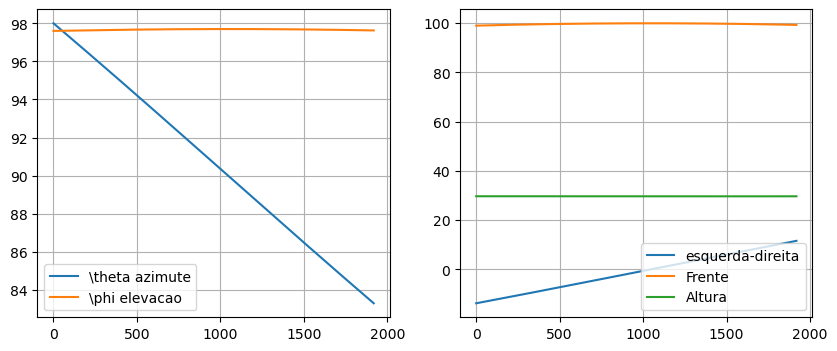

In [385]:
vector_angles = []
vector_cartesian = []
time_vector = []
rotation_angle = np.deg2rad(7)
rotatation_matrix = rot_x(rotation_angle)
for i in range(1920): # X

    coordinates = (i, 0,
                   i, 0)
    time_vector.append(i)
    theta_azimute, phi_elevation = get_angles(data, coordinates)
    vector_angles.append((theta_azimute, phi_elevation, radius))

    radius = 100
    x = radius * np.sin(phi_elevation) * np.cos(theta_azimute)
    y = radius * np.sin(phi_elevation) * np.sin(theta_azimute)
    z = radius * np.cos(phi_elevation)
    xyz_rotated = rotatation_matrix@np.array([[x],[y],[z]])
    vector_cartesian.append((xyz_rotated.reshape(1,-1))[0])
    # print(round(np.cos(theta_h),2), round(np.sin(np.pi - theta_v),2))
    # print(x,y,z)

# plt.plot(time_vector, [a[0] for a in vector_cartesian], label='x')
# plt.plot(time_vector, [a[1] for a in vector_cartesian], label='y')
plt.figure(figsize=(10,4))
plt.subplot(121)  
plt.plot(time_vector, np.rad2deg([a[0] for a in vector_angles]), label='\\theta azimute')
plt.plot(time_vector, np.rad2deg([a[1] for a in vector_angles]), label='\phi elevacao')
plt.legend()
plt.grid()
plt.subplot(122)  
plt.plot(time_vector, [a[0] for a in vector_cartesian], label='esquerda-direita')
plt.plot(time_vector, [a[1] for a in vector_cartesian], label='Frente')  
plt.plot(time_vector, [a[2] + altura_camera for a in vector_cartesian], label='Altura')
plt.legend()
plt.grid()
plt.show()

### Calcular distancia pra catenaria

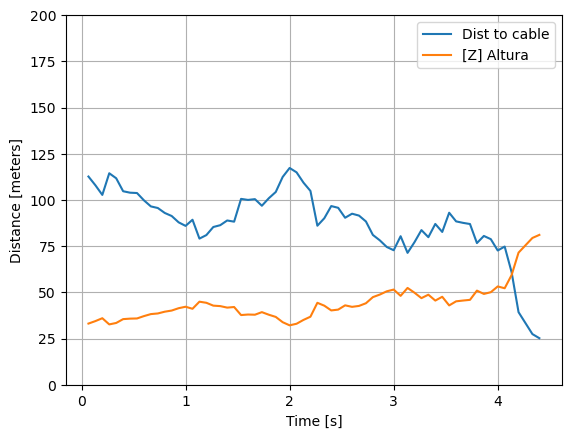

In [373]:
from scipy.optimize import newton
from scipy.optimize import minimize


# Dados do cabo
w = 2.2204  # kgf/m
T0 = 3095.3485  # kgf
L = 828.64  # m
h = -0  # m (desnível)

altura_torre = (115360 + 9640) * 10**-3
metade_horizontal = 14300 * 10**-3

# Parâmetro da catenária
a = T0 / w

# Função para calcular a catenária nivelada (h = 0)
def catenaria(x):
    return a * np.cosh(x / a)

# Flecha (nívelada)
f = catenaria(L/2) - a

y = np.linspace(-L/2, L/2, 500) + L/2 # Frente
z = catenaria(y)-a+altura_torre-f  # Ajuste para y=0 no ponto mais baixo
x_menos = np.ones(y.shape)*(-metade_horizontal)
x_mais = np.ones(y.shape)*(metade_horizontal)


def distance_to_catenary(vector_cartesian):
    distances = []
    for bird_pos in vector_cartesian:
        x_bird, y_bird, z_bird = bird_pos

        min_distance = 9999
        final_result = 0
        for x_cable in [-metade_horizontal, metade_horizontal]:
            def objective_function(y):
                # Calculate the distance between the point and the catenary at a given y
                z_catenary = catenaria(y-L/2)-a+altura_torre-f
                distance = np.sqrt((x_cable - x_bird)**2 + (y - y_bird)**2 + (z_catenary - z_bird)**2)
                return distance

            # Use minimize to find the y that minimizes the distance
            result = minimize(objective_function, y_bird, bounds=[(0, L)]) #bounds=[(min(y), max(y))]
            if min_distance > result.fun:
                final_result = result

        optimal_y = final_result.x[0]
        min_distance = final_result.fun
        distances.append(min_distance)
    return distances

distances = distance_to_catenary(vector_cartesian)
plt.plot(time_vector, distances, label="Dist to cable")
plt.plot(time_vector, [a[2] + altura_camera for a in vector_cartesian]  , label='[Z] Altura')
plt.ylim([0,200]), plt.grid(), plt.legend()
plt.xlabel("Time [s]"), plt.ylabel("Distance [meters]")
plt.show()

In [ ]:

CONSTANT = metade_horizontal #14.3

def distance_to_catenary(point):
    x, y_point, z_point = point

    def objective_function(y):
        # Calculate the distance between the point and the catenary at a given y
        z_catenary = catenaria(y-L/2)-a+altura_torre-f
        distance = np.sqrt((CONSTANT - x)**2 + (y - y_point)**2 + (z_catenary - z_point)**2)
        return distance

    # Use minimize to find the y that minimizes the distance
    result = minimize(objective_function, y_point, bounds=[(0, L)]) #bounds=[(min(y), max(y))]
    
    optimal_y = result.x[0]
    min_distance = result.fun
    return min_distance, optimal_y

# Example usage:
# Assuming you have a point [x, y, z]
# point = np.array([10, 500, 100])  # Example point
# min_distance, optimal_y = distance_to_catenary(point)
# print(f"Minimum distance to catenary: {min_distance:.2f}")
# print(f"Optimal y on catenary: {optimal_y:.2f}")

In [334]:
vector_cartesian

[array([-13.80053804,  99.12091267,  -1.85693378]),
 array([-13.78772323,  99.12109   ,  -1.84389146]),
 array([-13.77490914,  99.12126547,  -1.8308501 ]),
 array([-13.7620929 ,  99.12143912,  -1.8178068 ]),
 array([-13.74927743,  99.12161128,  -1.80476442]),
 array([-13.73645981,  99.12178161,  -1.79172009]),
 array([-13.72364296,  99.12195046,  -1.77867669]),
 array([-13.71082393,  99.1221173 ,  -1.76563136]),
 array([-13.69800425,  99.12228267,  -1.7525855 ]),
 array([-13.68518531,  99.12244637,  -1.7395406 ]),
 array([-13.67236422,  99.12260824,  -1.72649375]),
 array([-13.65954244,  99.12276845,  -1.71344639]),
 array([-13.64672142,  99.12292699,  -1.70039998]),
 array([-13.63389827,  99.12308389,  -1.68735161]),
 array([-13.62107442,  99.12323894,  -1.67430276]),
 array([-13.60825132,  99.12339232,  -1.66125487]),
 array([-13.59542609,  99.12354406,  -1.648205  ]),
 array([-13.58260019,  99.12369414,  -1.63515464]),
 array([-13.5697736 ,  99.12384257,  -1.62210377]),
 array([-13.

### Check: Usar uma imagem onde sabemos as posições

In [160]:
radius = 840
altura_torre = (115360 + 9640) * 10**-3
vector_cartesian = []

for pair_point in ref_point:
    coordinates = (pair_point[0], pair_point[1], pair_point[0], pair_point[1])
    theta_azimute, phi_polar =get_angles(data,coordinates,True)
    x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
    y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
    z = radius * np.cos(theta_azimute)
    vector_cartesian.append(np.array([x, y, z]))

print(f" Posicao X dos objetosvector_cartesian)")
np.sqrt(sum( (vector_cartesian[0]- vector_cartesian[1])**2))

pixesl (1023.0,240.0) 	-> normalized pos: (-0.0031, -0.1, 1) 	-> angle (azimute, polar): (90.2º, 95.9º) 	-> 800*cos: (-2.5,-81.6)
pixesl (1023.0,240.0) 	-> normalized pos: (-0.0031, -0.1, 1) 	-> angle (azimute, polar): (90.2º, 95.9º) 	-> 800*cos: (-2.5,-81.6)
pixesl (666.0,432.0) 	-> normalized pos: (-0.051, -0.076, 1) 	-> angle (azimute, polar): (92.9º, 94.4º) 	-> 800*cos: (-41.1,-60.8)
pixesl (1115.0,602.0) 	-> normalized pos: (0.0094, -0.053, 1) 	-> angle (azimute, polar): (89.5º, 93.0º) 	-> 800*cos: (7.5,-42.4)
pixesl (1300.0,484.0) 	-> normalized pos: (0.034, -0.069, 1) 	-> angle (azimute, polar): (88.0º, 94.0º) 	-> 800*cos: (27.5,-55.2)
 Posicao X dos objetosvector_cartesian)


0.0

In [347]:
img = cv2.imread('foto3.jpg')
radius = 829
ref_point = []
ref_3d_point = []
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at pixel (x, y): ({x}, {y})")
        ref_point.append((x,y))
        theta_azimute, phi_polar =get_angles(data,(x,y,x,y),True)
        x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
        y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
        z = radius * np.cos(theta_azimute)
        ref_3d_point.append(np.array([x,y,z]))
        # cv2.putText(img,f"({x:.0f}, {y:.0f},{z:.0f})",ref_point[-1],1,1,(255,0,0),1)
        cv2.putText(img,f"(altura= {z+altura_camera:.0f})",ref_point[-1],1,1,(255,0,0),2)
        if len(ref_3d_point) > 1:
            cv2.line(img,ref_point[-2],ref_point[-1],(0,255,0),1)
            midle_x = int((ref_point[-2][0]+ref_point[-1][0])/2)
            midle_y = int((ref_point[-2][1]+ref_point[-1][1])/2)
            dist = np.sqrt(sum( (ref_3d_point[-1]- ref_3d_point[-2])**2))
            cv2.putText(img,f"{dist:.1f} m",(midle_x,midle_y+10), 1,1,(0,255,255),2)
            cv2.putText(img,f"Distancia entre objetos calculada usando distancia {radius:.0f} m",(10,20), 1,1,(0,255,255),2)
        cv2.imshow('image', img)
            # cv2.putText()


# Create a window and set the callback function
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

ref_point

Clicked at pixel (x, y): (992, 873)
pixesl (992.0,873.0) 	-> normalized pos: (-0.0073, -0.016, 1) 	-> angle (azimute, polar): (90.4º, 90.9º) 	-> 800*cos: (-5.8,-12.9)
Clicked at pixel (x, y): (903, 878)
pixesl (903.0,878.0) 	-> normalized pos: (-0.019, -0.015, 1) 	-> angle (azimute, polar): (91.1º, 90.9º) 	-> 800*cos: (-15.5,-12.4)


[(992, 873), (903, 878)]

### Encontrar a Rotação da camera 

Considerar a rotação "cima baixo da camera" (usar rotação no eixo X):
https://en.wikipedia.org/wiki/Rotation_matrix

In [348]:
def rot_x(theta):
    rot_matrix = np.array([
        [1,        0,           0       ],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return(rot_matrix)

def MSE_rot(theta,ref_3d_point,altura_camera,altura_torre):
    rot_matrix = rot_x(theta)
    MSE = 0
    for point in ref_3d_point:
        point.resize(3,1)
        calculeted = (rot_matrix@point)[2] + altura_camera
        calculeted = np.sin(theta)*point[1] + np.cos(theta)*point[2] + altura_camera
        error = calculeted - altura_torre
        MSE += error**2
    MSE = MSE/len(ref_3d_point)

    return MSE

MSE_rot(1,ref_3d_point,altura_camera,altura_torre)

def find_error(theta,point,altura_camera,altura_torre):
    # rot_matrix = rot_x(theta)
    
    # for point in ref_3d_point:
    point.resize(3,1)
    # calculeted = (rot_matrix@point)[2] + altura_camera
    calculeted = np.sin(theta)*point[1] + np.cos(theta)*point[2] + altura_camera
    error = (calculeted - altura_torre)**2        

    return error

find_error(3,ref_3d_point[0],altura_camera,altura_torre)


array([830.30258759])

$\min_{\theta} \{ h_{calculated} (\theta) - h_{real}$ \} = 
$\min_{\theta} \{ (R_x(\theta) Pos_z + h_{camera}) - h_{real}$ \}

In [349]:
from scipy.optimize import minimize

# theta_opt = minimize(lambda x: MSE_rot(x,ref_3d_point,altura_camera,altura_torre), 1)
num_point = 0
values = []
for num_point in range(len(ref_3d_point)):
    theta_opt = minimize(lambda x: find_error(x,ref_3d_point[num_point],altura_camera,altura_torre), np.deg2rad(5))
    print(theta_opt.success, theta_opt.message)
    values.append(theta_opt.x)
    print("Error found: ",find_error(theta_opt.x,ref_3d_point[num_point],altura_camera,altura_torre))

print(f"\nValues found ({np.rad2deg(values)} degrees)")


True Optimization terminated successfully.
Error found:  [3.76483909e-11]
True Optimization terminated successfully.
Error found:  [3.76514771e-11]

Values found ([[6.93922503]
 [7.62871867]] degrees)


Using $\theta = 7$ degree

In [285]:
img = cv2.imread('foto3.jpg')
radius = 840
rot_angle = np.deg2rad(5)
rot_matrix = rot_x(rot_angle)
ref_point = []
ref_3d_point = []
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at pixel (x, y): ({x}, {y})")
        ref_point.append((x,y))
        theta_azimute, phi_polar =get_angles(data,(x,y,x,y),True)
        x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
        y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
        z = radius * np.cos(theta_azimute)
        xyz_rotated = rot_matrix@np.array([[x],[y],[z]])
        ref_3d_point.append( (xyz_rotated.reshape(1,-1))[0])
        # cv2.putText(img,f"({x:.0f}, {y:.0f},{z:.0f})",ref_point[-1],1,1,(255,0,0),1)
        cv2.putText(img,f"(altura= {ref_3d_point[-1][2]+altura_camera:.0f})",ref_point[-1],1,1,(255,0,0),2)
        if len(ref_3d_point) > 1:
            cv2.line(img,ref_point[-2],ref_point[-1],(0,255,0),1)
            midle_x = int((ref_point[-2][0]+ref_point[-1][0])/2)
            midle_y = int((ref_point[-2][1]+ref_point[-1][1])/2)
            dist = np.sqrt(sum( (ref_3d_point[-1]- ref_3d_point[-2])**2))
            cv2.putText(img,f"{dist:.1f} m",(midle_x,midle_y+10), 1,1,(0,255,255),2)
            cv2.putText(img,f"Distancia entre objetos calculada usando distancia {radius:.0f} m",(10,20), 1,1,(0,255,255),2)
        cv2.imshow('image', img)
            # cv2.putText()


# Create a window and set the callback function
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()



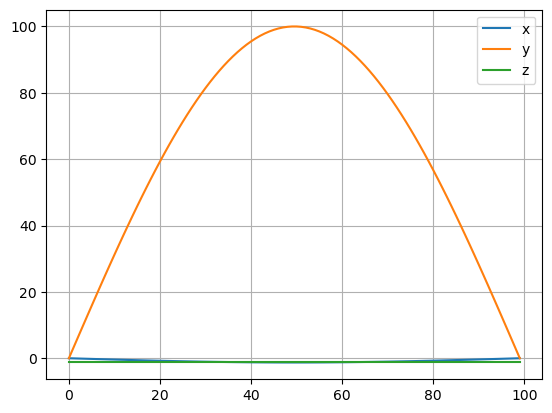

In [11]:
vector_cartesian = []
time_vector = []
for i,phi_polar in enumerate(np.linspace(0, np.pi, 100)):
    time_vector.append(i)
    x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
    y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
    z = radius * np.cos(theta_azimute)
    vector_cartesian.append((x, y, z))
    # print(round(np.cos(theta_h),2), round(np.sin(np.pi - theta_v),2))
    # print(x,y,z)

# plt.plot(time_vector, np.rad2deg([a[0] for a in vector_angles]), label='\\theta')
# plt.plot(time_vector, np.rad2deg([a[1] for a in vector_angles]), label='\phi')
# plt.legend()
# # plt.ylim(np.deg2rad(-10), np.deg2rad(10))
# plt.grid()
# plt.show()

plt.plot(time_vector, [a[0] for a in vector_cartesian], label='x')
plt.plot(time_vector, [a[1] for a in vector_cartesian], label='y')  
plt.plot(time_vector, [a[2] for a in vector_cartesian], label='z')
plt.legend()
plt.grid()
plt.show()